The times taken to query the base galaxy Table using obsMetadata and instance Catalogs is much larger than the time to query the galaxy table on fatboy directly. This records timeit results for these queries

## Setup

In [261]:
from __future__ import division, print_function, absolute_import

In [262]:
import time
import os
import pandas as pd
import numpy as np

In [263]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
sns.set()

In [264]:
from lsst.sims.catalogs.measures.instance import InstanceCatalog
import lsst.sims.catUtils.baseCatalogModels as bcm
from lsst.sims.catalogs.generation.db import CatalogDBObject, DBObject
from lsst.sims.catUtils.baseCatalogModels.GalaxyModels import GalaxyTileObj, GalaxyObj
from lsst.sims.utils import ObservationMetaData

/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


## Observation Meta Data

In [265]:
# Shifted to corner
observerMetaData_2 = ObservationMetaData(boundType='box',
                                  pointingRA=2.,
                                  pointingDec=2.,
                                  boundLength=1.)

In [79]:
# Shifted to corner
observerMetaData_1 = ObservationMetaData(boundType='box',
                                  pointingRA=2.,
                                  pointingDec=2.,
                                  boundLength=2.)

In [80]:
# Original Base
observerMetaData = ObservationMetaData(boundType='box',
                                  pointingRA=0.,
                                  pointingDec=0.,
                                  boundLength=2.)

In [106]:
# Shifted to corner
observerMetaData_3 = ObservationMetaData(boundType='box',
                                  pointingRA=2.,
                                  pointingDec=2.,
                                  boundLength=0.5)

In [107]:
observerMetaData.boundLength

2.0

In [124]:
def queryObsMetaData(obsMetaData):
    ra, dec, size = obsMetaData.pointingRA, obsMetaData.pointingDec, obsMetaData.boundLength
    raSize , decSize = (size, size)
    coords = np.asarray([ra - size, ra + size, dec - size, dec + size])
    
    coordTrans = np.remainder(coords + size, np.repeat(4., 4)) - size
    coordWraps =  np.floor_divide(coords[[1,3]] - coords[[0,2]] , (4,4))
    querylims = coordTrans[2], coordTrans[0], coordTrans[3], coordTrans[1]
    
    
    if coordTrans[2] < coordTrans[0]:
        print('split')
    if coordTrans[3] < coordTrans[1]:
        print('split')
        
    #bounds = [Polygon(vert, fill=False, lw=2, alpha=1., ls='dashed') for vert in verts]
    return coords, coordTrans, coordWraps, querylims


In [125]:
queryObsMetaData(observerMetaData)

(array([-2.,  2., -2.,  2.]),
 array([-2., -2., -2., -2.]),
 array([ 1.,  1.]),
 (-2.0, -2.0, -2.0, -2.0))

In [126]:
queryObsMetaData(observerMetaData_1)

(array([ 0.,  4.,  0.,  4.]),
 array([ 0.,  0.,  0.,  0.]),
 array([ 1.,  1.]),
 (0.0, 0.0, 0.0, 0.0))

In [127]:
queryObsMetaData(observerMetaData_2)

(array([ 1.,  3.,  1.,  3.]),
 array([ 1., -1.,  1., -1.]),
 array([ 0.,  0.]),
 (1.0, 1.0, -1.0, -1.0))

In [128]:
queryObsMetaData(observerMetaData_3)

(array([ 1.5,  2.5,  1.5,  2.5]),
 array([ 1.5,  2.5,  1.5,  2.5]),
 array([ 0.,  0.]),
 (1.5, 1.5, 2.5, 2.5))

In [129]:
queryObsMetaData(observerMetaData_3)

(array([ 1.5,  2.5,  1.5,  2.5]),
 array([ 1.5,  2.5,  1.5,  2.5]),
 array([ 0.,  0.]),
 (1.5, 1.5, 2.5, 2.5))

In [30]:
def tileObsMetaData(obsMetaData, num):
    ra, dec, size = obsMetaData.pointingRA, obsMetaData.pointingDec, obsMetaData.boundLength
    blen = size / num
    pras = np.arange(ra - size, ra + size, 2.0 *blen) + blen
    pdecs = np.arange(dec - size, dec + size, 2.0 * blen) + blen
    
    coords = np.dstack(np.meshgrid(pras, pdecs)).reshape(len(pras) * len(pdecs), 2)
    obsmdata = [ObservationMetaData(boundType='box',
                                  pointingRA=coords[i, 0],
                                  pointingDec=coords[i, 1],
                                  boundLength=blen) for i in range(len(coords))]
    # return coords
    diffvec = np.array([blen, blen])
    transvec = np.array([1, -1])
    verts = [[coord - diffvec, coord - transvec * diffvec, coord + diffvec, coord + diffvec *transvec] for coord in coords]  
    bounds = [Polygon(vert, fill=False, lw=2, alpha=1., ls='dashed') for vert in verts]
    return obsmdata, coords, bounds



(-2.0, 2.0)

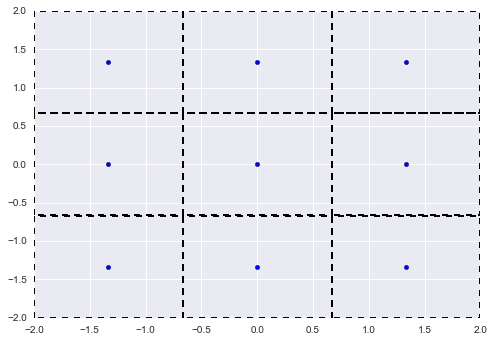

In [31]:
tiledObsMD, coords, bounds = tileObsMetaData(observerMetaData, 3)
fig, ax =plt.subplots()
ax.scatter(coords[:,0], coords[:, 1])
for bound in bounds:
    ax.add_patch(bound)
ax.set_xlim(-2., 2.)
ax.set_ylim(-2., 2.)

In [ ]:
len(tiledObsMD)

In [ ]:
class galCopy(InstanceCatalog):
    column_outputs = ['galtileid', 'raJ2000', 'decJ2000', 'redshift']#, 'a_d', 'b_d', 'pa_disk', 'mass_stellar', 'absmag_r_total']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e', 
                        'mass_stellar': '%8e', 'absmag_r_total': '%8e'}

In [ ]:
def writeCat(obsMD=tiledObsMD, redshiftmax=0.4, fname='gB-test', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyTiled = GalaxyTileObj()
    print(len(obsMD))
    filenames = []
    for i, obsMetaData in enumerate(obsMD):
        filename = fname  + '{}'.format(i) + '.csv'
        filenames.append(filename)
        galaxyBase = galCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
        galaxyBase.write_catalog(filename, chunkSize)
    return filenames

In [ ]:
# No need
def writeCatBase(redshiftmax=0.4, fname='gB-test.csv', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyTiled = GalaxyObj()
    galaxyBase = galBaseCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
    galaxyBase.write_catalog(fname, chunkSize)

In [ ]:
tileObsMD, coords, bounds = tileObsMetaData(observerMetaData, 1)

In [ ]:
len(tileObsMD)

In [ ]:
%%timeit
chunksize = None
tstart = time.time()
fnames = writeCat(obsMD=tileObsMD, chunkSize=chunksize)
print(fnames)
tend = time.time()
print(tend - tstart)
numlines = 0

In [ ]:
tileObsMD, coords, bounds = tileObsMetaData(observerMetaData, 2)

In [ ]:
%%timeit
chunksize = None
tstart = time.time()
fnames = writeCat(obsMD=tileObsMD, chunkSize=chunksize)
print(fnames)
tend = time.time()
print(tend - tstart)
numlines = 0

In [ ]:
tileObsMD, coords, bounds = tileObsMetaData(observerMetaData, 3)

In [ ]:
%%timeit
chunksize = None
tstart = time.time()
fnames = writeCat(obsMD=tileObsMD, chunkSize=chunksize)
print(fnames)
tend = time.time()
print(tend - tstart)
numlines = 0

In [ ]:
query = """EXECUTE [LSSTCATSIM].[dbo].[GalaxySearch2015l]
                   @ApertureStr = 'REGION RECT J2000 358.000000 -2.000000 2.000000 2.000000', @ColumnNames = 'dec as decJ2000,ra as raJ2000,redshift as redshift',
                   @ComponentSubset = 'ALL' , @WhereClause = 'redshift < 0.4’
        """


In [ ]:
numLines = 1
for i in range(9):
    fname = "gB-test{}.csv".format(i)
    with open(fname, 'r') as fp:
        numLines += sum(1 for line in fp) - 1 

In [ ]:
print(numLines)

In [ ]:
!tail gB-test0.csv

In [ ]:
!wc -l *.csv

In [ ]:
def writeDBObjBase(redshiftmax=0.4, fname='gB-test.csv', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyBase = GalaxyTileObj()
    # galDB = dbobject = DBObject(database=config.database, driver='mssql+pymssql', host=config.host, port=config.port, connection=None)
    #galaxyBase = galBaseCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
    query = """SELECT galtileid, raJ2000, decJ2000, redshift FROM galaxy WHERE redshift < 0.4 AND raJ2000 < 2 and raJ2000 > -2 and decJ2000 < 2 and decJ2000 > -2"""
    x = galaxyBase.execute_arbitrary(query)
    print(len(x), len(x[0]))
    #galaxyBase.write_catalog(fname, chunkSize)

In [ ]:
def writeDBObjBase(redshiftmax=0.4, fname='gB-test.csv', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyBase = GalaxyObj()
    # galDB = dbobject = DBObject(database=config.database, driver='mssql+pymssql', host=config.host, port=config.port, connection=None)
    #galaxyBase = galBaseCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
    query = """SELECT id, ra, dec, redshift WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
    x = galaxyBase.execute_arbitrary(query)
    print(len(x), len(x[0]))
    #galaxyBase.write_catalog(fname, chunkSize)

In [ ]:
%%timeit
chunksize = None
tstart = time.time()
writeDBObjBase(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
chunksize = None
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
chunksize = 50000
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
chunksize = 500000
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
chunksize = 5000
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
chunksize = 50
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
# No need
class galBaseCopy(InstanceCatalog):
    column_outputs = ['id', 'raJ2000', 'decJ2000', 'redshift']#, 'a_d', 'b_d', 'pa_disk', 'mass_stellar', 'absmag_r_total']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e', 
                        'mass_stellar': '%8e', 'absmag_r_total': '%8e'}

## Direct query with fetch

In [7]:
from lsst.utils import getPackageDir
from lsst.daf.persistence import DbAuth
import lsst.pex.config as pexConfig
import pymssql

In [ ]:
def build_queries(obsMetaData):
    
    

In [23]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 1.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

7158432 4
26.2782211304
7158432 4
26.472784996
7158432 4
27.5812399387
7158432 4
25.6039869785
1 loops, best of 3: 25.6 s per loop


In [15]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 1 and ra > 0 and dec < 1 and dec > 0"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print((tend - tstart) * 16.)

56924 4
14.428352356
56924 4
12.6928939819
56924 4
12.1693763733
56924 4
13.5419692993
1 loops, best of 3: 761 ms per loop


In [ ]:
%%timeit

tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [17]:
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)



In [22]:
%%timeit

tstart = time.time()
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 1.4 AND ra < 1 and ra > -0 and dec < 1 and dec > -0"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(16.0*(tend - tstart))

453911 4
39.7260627747
453911 4
46.1514549255
453911 4
38.8499031067
453911 4
38.8650894165
1 loops, best of 3: 2.43 s per loop


In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """EXECUTE [LSSTCATSIM].[dbo].[GalaxySearch2015]
                   @ApertureStr = 'REGION RECT J2000 358.000000 -2.000000 2.000000 2.000000', @ColumnNames = 'dec as decJ2000,ra as raJ2000,redshift as redshift',
                   @ComponentSubset = 'ALL' , @WhereClause = 'redshift < 0.4'
"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """[LSSTCATSIM].[dbo].[GalaxySearch2015]
                   @ApertureStr = 'REGION RECT J2000 358.000000 -2.000000 2.000000 2.000000', @ColumnNames = 'dec as decJ2000,ra as raJ2000,redshift as redshift',
                   @ComponentSubset = 'ALL' , @WhereClause = 'redshift < 0.4'"""

db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
num = 50000
x = db.fetchmany(num)
while len(x)>0:
    x = db.fetchmany(num)
# print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [ ]:
!pwd

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
num = 50000
x = db.fetchmany(num)
while len(x) > 0:
    x = db.fetchmany(num)
# print(len(x), len(x[0]))
#df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
#df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT galaxy.id AS id, ra*PI()/180. AS [raJ2000], dec*PI()/180. AS [decJ2000], galaxy.redshift AS redshift 
FROM galaxy  WITH(FORCESEEK) JOIN (SELECT htmidstart, htmidend 
FROM fHtmCoverRegion(%(fHtmCoverRegion_1)s)) AS anon_1 ON galaxy.htmid BETWEEN anon_1.htmidstart AND anon_1.htmidend 
WHERE sph.fRegionContainsXYZ(sph.fSimplifyString(%(fSimplifyString_1)s), galaxy.cx, galaxy.cy, galaxy.cz) = %(fRegionContainsXYZ_1)s
"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

In [ ]:
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)



In [ ]:
config

In [ ]:
dbobject = DBObject(database=config.database, driver='mssql+pymssql', host=config.host, port=config.port, connection=None)

In [ ]:
dbobject.execute_arbitrary()

## Test Rotations

In [5]:
deltaAng =  np.radians(2)

In [228]:
coords = np.random.uniform((- deltaAng + np.pi/2., -deltaAng), (deltaAng + np.pi/2., deltaAng), size=(10e5, 2))

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


In [229]:
df = pd.DataFrame(coords, columns=['theta', 'phi'])

In [230]:
df.describe()

,theta,phi
count,1000000.000000,1000000.000000
mean,1.570814,0.000032
std,0.020159,0.020149
min,1.535890,-0.034907
25%,1.553359,-0.017425
50%,1.570810,0.000062
75%,1.588290,0.017476
max,1.605703,0.034907


In [231]:
def rotation(df, delta=0):
    """
    delta : int
    """
    d = delta
    delta = np.radians(delta * 4.0)
    cosDelta = np.cos(delta)
    sinDelta = np.sin(delta)
    
    sintheta = np.sin(df.theta)
    costheta = np.cos(df.theta)
    cosphi = np.cos(df.phi)
    # sinphi = np.sin(df.phi)
    
    zprime =  costheta * cosDelta - sinDelta * sintheta * cosphi
    xprime = sintheta * cosphi * cosDelta + costheta * sinDelta
    # yprime = sintheta * sinphi
    
    #rlat = np.sqrt(xprime **2. + yprime **2.)
    rlat = np.sqrt(1.0 - zprime**2)
    #print(min(rlat), max(rlat))
    thetaprime = 'thetaprime_{}'.format(int(d))
    phiprime = 'phiprime_{}'.format(d)
    df[phiprime] = np.arccos(xprime / rlat)
    #df['x'] = sintheta * cosphi
    #df['y'] = sintheta * sinphi
    #df['z'] = costheta
    #df['xprime'] = xprime
    #df['yprime'] = yprime
    #df['zprime'] = zprime
    df[thetaprime] = np.arccos(zprime)
    #df[thetaprime] = np.arctan(rlat/zprime) 
    #df.thetaprime[df[thetaprime] < 0 ] += np.pi
    #df[thetaprime] = np.arcsin(np.sqrt(xprime**2. + yprime**2))#*np.sign(zprime)
    # df[thetaprime] = np.arcsin(rlat) * np.sign(zprime)

In [232]:
%timeit rotated(df, delta=0)

1 loops, best of 3: 164 ms per loop


In [233]:
%timeit rotated(df, delta=1)

1 loops, best of 3: 159 ms per loop


In [234]:
%timeit rotated(df, delta=4)

10 loops, best of 3: 162 ms per loop


In [219]:
%timeit rotation(df, delta=1)

1 loops, best of 3: 1.15 s per loop


In [217]:
%timeit rotation(df, delta=4)

1 loops, best of 3: 1.18 s per loop


In [ ]:
def rotated(df, delta=0):
    """
    delta : int
    """
    d = delta
    delta = np.radians(delta * 4.0)
    cosDelta = np.cos(delta)
    sinDelta = np.sin(delta)
    
    sintheta = np.sin(df.theta)
    costheta = np.cos(df.theta)
    cosphi = np.cos(df.phi)
    sinphi = np.sin(df.phi)
    
    zprime =  costheta * cosDelta - sinDelta * sintheta * cosphi
    xprime = sintheta * cosphi * cosDelta + costheta * sinDelta
    yprime = sintheta * sinphi
    
    rlat = np.sqrt(xprime **2. + yprime **2.)
    #print(min(rlat), max(rlat))
    thetaprime = 'thetaprime_{}'.format(int(d))
    phiprime = 'phiprime_{}'.format(d)
    df[phiprime] = np.arcsin(yprime / rlat)
    df['x'] = sintheta * cosphi
    df['y'] = sintheta * sinphi
    df['z'] = costheta
    df['xprime'] = xprime
    df['yprime'] = yprime
    df['zprime'] = zprime
    df[thetaprime] = np.arccos(zprime)
    #df[thetaprime] = np.arctan(rlat/zprime) 
    #df.thetaprime[df[thetaprime] < 0 ] += np.pi
    #df[thetaprime] = np.arcsin(np.sqrt(xprime**2. + yprime**2))#*np.sign(zprime)
    # df[thetaprime] = np.arcsin(rlat) * np.sign(zprime)

In [195]:
def rotated(df, delta=0):
    """
    delta : int
    """
    d = delta
    delta = np.radians(delta * 4.0)
    cosDelta = np.cos(delta)
    sinDelta = np.sin(delta)
    
    sintheta = np.sin(df.theta)
    costheta = np.cos(df.theta)
    cosphi = np.cos(df.phi)
    sinphi = np.sin(df.phi)
    
    zprime =  costheta * cosDelta - sinDelta * sintheta * cosphi
    xprime = sintheta * cosphi * cosDelta + costheta * sinDelta
    yprime = sintheta * sinphi
    
    rlat = np.sqrt(xprime **2. + yprime **2.)
    #print(min(rlat), max(rlat))
    thetaprime = 'thetaprime_{}'.format(int(d))
    phiprime = 'phiprime_{}'.format(d)
    df[phiprime] = np.arcsin(yprime / rlat)
    df['x'] = sintheta * cosphi
    df['y'] = sintheta * sinphi
    df['z'] = costheta
    df['xprime'] = xprime
    df['yprime'] = yprime
    df['zprime'] = zprime
    df[thetaprime] = np.arccos(zprime)
    #df[thetaprime] = np.arctan(rlat/zprime) 
    #df.thetaprime[df[thetaprime] < 0 ] += np.pi
    #df[thetaprime] = np.arcsin(np.sqrt(xprime**2. + yprime**2))#*np.sign(zprime)
    # df[thetaprime] = np.arcsin(rlat) * np.sign(zprime)

In [66]:
#def rotated(df, delta=0):
    """
    delta : int
    """
    d = delta
    delta = np.radians(delta * 4.0)
    cosDelta = np.cos(delta)
    sinDelta = np.sin(delta)
    
    sintheta = np.sin(df.theta)
    costheta = np.cos(df.theta)
    cosphi = np.cos(df.phi)
    
    costhetaprime =  costheta * cosDelta - sinDelta * sintheta * cosphi
    sinthetaprime = np.sqrt(1.0 - costhetaprime**2.) * np.sign(df.theta)
    cosphiprime = (sintheta * cosphi * cosDelta + costheta * sinDelta ) /sinthetaprime
    df['costhetprime']= costhetaprime
    df['cosphiprime'] = cosphiprime
    df['thetaprime'] = np.arcsin(sinthetaprime)
    df['phiprime'] = np.arcsin(cosphiprime) * np.sign(df.phi)
    

IndentationError: unexpected indent (<ipython-input-66-49a29755f319>, line 2)

In [113]:
_ = np.arcsin(np.arange(-1., 1., 0.01))

In [135]:
ratio = lambda x: (np.arccos(x) - np.arccos(0.) ) / np.arcsin(x)

In [139]:
ratio(1.0e-5)

-0.99999999998988442

In [124]:
np.arccos(np.arange(-0., 1., 0.001))

array([ 1.57079633,  1.56979633,  1.56879633,  1.56779632,  1.56679632,
        1.56579631,  1.56479629,  1.56379627,  1.56279624,  1.56179621,
        1.56079616,  1.5597961 ,  1.55879604,  1.55779596,  1.55679587,
        1.55579576,  1.55479564,  1.55379551,  1.55279535,  1.55179518,
        1.55079499,  1.54979478,  1.54879455,  1.5477943 ,  1.54679402,
        1.54579372,  1.5447934 ,  1.54379305,  1.54279267,  1.54179226,
        1.54079182,  1.53979136,  1.53879086,  1.53779033,  1.53678977,
        1.53578918,  1.53478855,  1.53378788,  1.53278718,  1.53178643,
        1.53078565,  1.52978483,  1.52878397,  1.52778306,  1.52678212,
        1.52578113,  1.52478009,  1.52377901,  1.52277788,  1.5217767 ,
        1.52077547,  1.51977419,  1.51877286,  1.51777148,  1.51677005,
        1.51576856,  1.51476702,  1.51376542,  1.51276376,  1.51176204,
        1.51076027,  1.50975843,  1.50875654,  1.50775458,  1.50675256,
        1.50575047,  1.50474832,  1.5037461 ,  1.50274381,  1.50

In [196]:
%timeit rotated(df, delta=2)

1 loops, best of 3: 1.65 s per loop


In [69]:
#rotated(df, delta=deltaAng*2.*3)

In [158]:
np.allclose(df.theta, df.thetaprime_0)

True

In [159]:
np.allclose(df.phi, df.phiprime_0)

True

(array([  999920.,   998351.,   999815.,   999791.,   999174.,  1000880.,
          998819.,  1000845.,  1000785.,  1001620.]),
 array([ -3.49065801e-02,  -2.79252638e-02,  -2.09439474e-02,
         -1.39626311e-02,  -6.98131474e-03,   1.59791914e-09,
          6.98131794e-03,   1.39626343e-02,   2.09439506e-02,
          2.79252670e-02,   3.49065833e-02]),
 <a list of 10 Patch objects>)

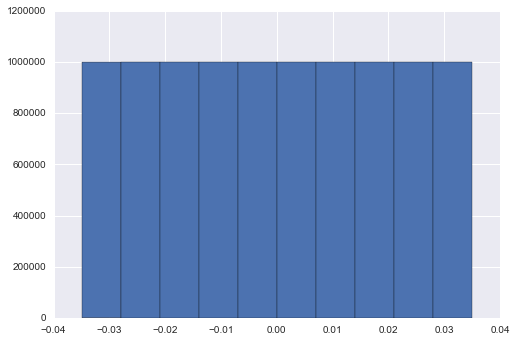

In [160]:
plt.hist(df.phi)

In [197]:
df.head()

,theta,phi,phiprime_0,x,y,z,xprime,yprime,zprime,thetaprime_0,phiprime_1,thetaprime_1,cosine,phiprime_2,thetaprime_2
0,1.585973,0.006567,0.006567,0.999863,0.006566,-0.015176,0.988021,0.006566,-0.154183,1.585973,0.006590,1.655785,0.997564,0.006645,1.725597
1,1.564978,0.020762,0.020762,0.999768,0.020761,0.005818,0.990848,0.020761,-0.133379,1.564978,0.020805,1.634776,0.997565,0.020949,1.704574
2,1.589663,-0.025131,-0.025131,0.999506,-0.025124,-0.018866,0.987154,-0.025124,-0.157787,1.589663,-0.025226,1.659454,0.997566,-0.025446,1.729245
3,1.570525,-0.012503,-0.012503,0.999922,-0.012503,0.000271,0.990228,-0.012503,-0.138893,1.570525,-0.012534,1.640333,0.997564,-0.012626,1.710140
4,1.575054,0.014608,0.014608,0.999884,0.014607,-0.004258,0.989561,0.014607,-0.143373,1.575054,0.014648,1.644860,0.997565,0.014760,1.714665


In [149]:
np.arctan(np.arange(-100., 100., 0.01)) + np.pi/2.

array([ 0.00999967,  0.01000067,  0.01000167, ...,  3.13158999,
        3.13159099,  3.13159199])

In [172]:
def angdist(df):
    df['cosine'] = df['x'] *df['xprime'] + df['y'] *df['yprime'] + df['z'] * df['zprime']

In [ ]:
df.dot()

In [173]:
angdist(df)

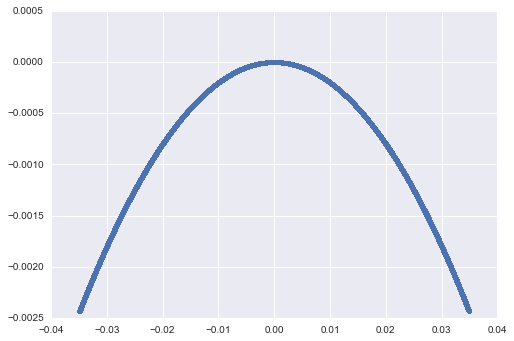

In [188]:
_ = plt.plot(df.phi, df.cosine.apply(np.arccos).apply(np.degrees) - 4.0, '.')

In [42]:
np.allclose(df.z, df.zprime)

True

In [44]:
np.arccos(df.z)

0          1.600919
1          1.591040
2          1.547572
3          1.562262
4          1.602375
5          1.602526
6          1.603551
7          1.551027
8          1.553097
9          1.565042
10         1.547829
11         1.547155
12         1.578807
13         1.540337
14         1.565705
15         1.585568
16         1.574220
17         1.586910
18         1.581206
19         1.588016
20         1.540386
21         1.545821
22         1.536262
23         1.578339
24         1.597536
25         1.575547
26         1.537745
27         1.556870
28         1.572113
29         1.574390
             ...   
9999970    1.581844
9999971    1.567750
9999972    1.541748
9999973    1.604572
9999974    1.579467
9999975    1.546369
9999976    1.543622
9999977    1.572320
9999978    1.541541
9999979    1.543620
9999980    1.585244
9999981    1.547942
9999982    1.545829
9999983    1.594852
9999984    1.543252
9999985    1.548165
9999986    1.585559
9999987    1.586699
9999988    1.602536


In [198]:
df_a = df.ix[np.random.random_integers(0, len(df), size=10000)]
df_b = df.ix[np.random.random_integers(0, len(df), size=10000)]

In [199]:
df_a.head()

,theta,phi,phiprime_0,x,y,z,xprime,yprime,zprime,thetaprime_0,phiprime_1,thetaprime_1,cosine,phiprime_2,thetaprime_2
4912658,1.564374,0.000507,0.000507,0.999979,0.000507,0.006422,0.991141,0.000507,-0.132811,1.564374,0.000508,1.634187,0.997564,0.000511,1.704001
3945132,1.583989,-0.027156,-0.027156,0.999544,-0.027151,-0.013192,0.987981,-0.027151,-0.152173,1.583989,-0.027248,1.653776,0.997566,-0.027474,1.723563
846632,1.566988,-0.022609,-0.022609,0.999737,-0.022607,0.003808,0.990538,-0.022607,-0.135366,1.566988,-0.022658,1.636784,0.997565,-0.022819,1.706579
4268614,1.566772,0.022700,0.022700,0.999734,0.022698,0.004024,0.990565,0.022698,-0.135151,1.566772,0.022749,1.636568,0.997565,0.022910,1.706363
9562793,1.545548,0.018679,0.018679,0.999507,0.018672,0.025245,0.993293,0.018672,-0.114105,1.545548,0.018691,1.615349,0.997565,0.018796,1.685150


In [191]:
df.ix[1]

theta           1.564978
phi             0.020762
phiprime_0      0.020762
x               0.999768
y               0.020761
z               0.005818
xprime          0.997738
yprime          0.020761
zprime         -0.063936
thetaprime_0    1.564978
phiprime_1      0.020805
thetaprime_1    1.634776
cosine          0.997565
Name: 1, dtype: float64

In [192]:
def angSep( df1, df2, theta, phi):
    th1 = df1[theta].values
    th2 = df2[theta].values
    ph1 = df1[phi].values
    ph2 = df2[phi].values

    cos = np.sin(th1)* np.sin(th2)* np.cos(ph1- ph2) + np.cos(th1)*np.cos(th2)
    return cos

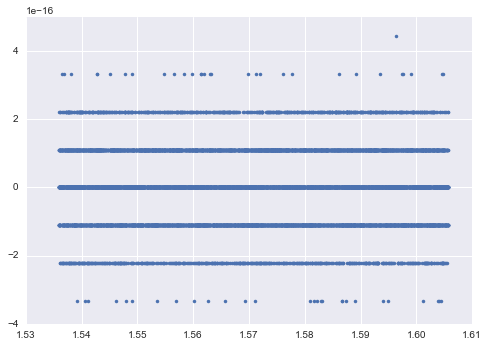

In [200]:
plt.plot(df_a['theta'] , 
         angSep(df_a, df_b, 'theta', 'phi')- angSep(df_a, df_b, 'thetaprime_2', 'phiprime_2'),'.')

In [167]:
x = angSep(df_a, df_b, 'theta', 'phi')- angSep(df_a, df_b, 'thetaprime', 'phiprime')

In [170]:
x

array([False, False, False, ..., False, False, False], dtype=bool)

In [160]:
np.max(x)

nan

In [164]:
len(x[np.isnan(x)])

1

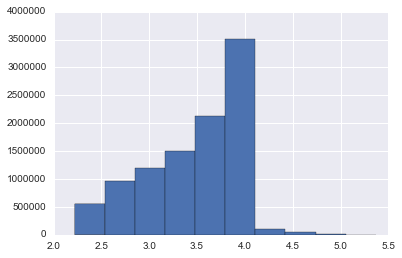

In [44]:
(df.thetaprime - df.theta).apply(np.degrees).hist()

In [51]:
df.theta.describe()

count    10000000.000000
mean            0.482313
std             0.298839
min            -0.034907
25%             0.223323
50%             0.482206
75%             0.741157
max             1.000000
Name: theta, dtype: float64

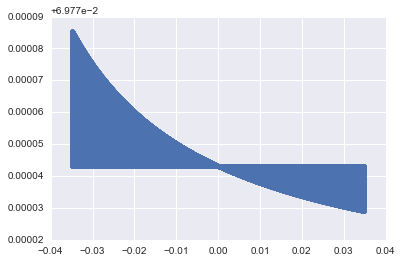

In [62]:
plt.plot(df.theta.astype(np.float).values, df.thetaprime.astype(np.float).values - df.theta.astype(np.float).values, '.')

In [37]:
len(df.theta)/1.0e6

10.0

In [31]:
x = rotated(df, delta=2*deltaAng) - df.theta.values

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([   74411.,    77435.,    80472.,    73698.,    31837.,        0.,
               0.,   228993.,  2615518.,  6817636.]),
 array([ -3.99999365e+00,  -3.19999431e+00,  -2.39999497e+00,
         -1.59999562e+00,  -7.99996282e-01,   3.06095169e-06,
          8.00002403e-01,   1.60000175e+00,   2.40000109e+00,
          3.20000043e+00,   3.99999977e+00]),
 <a list of 10 Patch objects>)

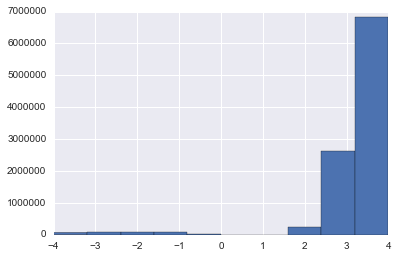

In [33]:
plt.hist(np.degrees(x))

In [171]:
!pwd

/Users/rbiswas/src/LSST/BenchmarkInstanceCatalogs/examples


##  Transformations

In [235]:
def rotated(df, delta=0):
    """
    delta : int
    """
    d = delta
    delta = np.radians(delta * 4.0)
    cosDelta = np.cos(delta)
    sinDelta = np.sin(delta)
    
    sintheta = np.sin(df.theta)
    costheta = np.cos(df.theta)
    cosphi = np.cos(df.phi)
    sinphi = np.sin(df.phi)
    
    zprime =  costheta * cosDelta - sinDelta * sintheta * cosphi
    xprime = sintheta * cosphi * cosDelta + costheta * sinDelta
    yprime = sintheta * sinphi
    
    rlat = np.sqrt(xprime **2. + yprime **2.)
    #print(min(rlat), max(rlat))
    thetaprime = 'thetaprime_{}'.format(int(d))
    phiprime = 'phiprime_{}'.format(d)
    df[phiprime] = np.arcsin(yprime / rlat)
    df['x'] = sintheta * cosphi
    df['y'] = sintheta * sinphi
    df['z'] = costheta
    df['xprime'] = xprime
    df['yprime'] = yprime
    df['zprime'] = zprime
    df[thetaprime] = np.arccos(zprime)
    #df[thetaprime] = np.arctan(rlat/zprime) 
    #df.thetaprime[df[thetaprime] < 0 ] += np.pi
    #df[thetaprime] = np.arcsin(np.sqrt(xprime**2. + yprime**2))#*np.sign(zprime)
    # df[thetaprime] = np.arcsin(rlat) * np.sign(zprime)

In [236]:
def angSep( df1, df2, theta, phi):
    th1 = df1[theta].values
    th2 = df2[theta].values
    ph1 = df1[phi].values
    ph2 = df2[phi].values

    cos = np.sin(th1)* np.sin(th2)* np.cos(ph1- ph2) + np.cos(th1)*np.cos(th2)
    return cos

###  Tests of rotation

In [237]:
deltaAng =  np.radians(2)

In [241]:
coords = np.random.uniform((- deltaAng + np.pi/2., -deltaAng), (deltaAng + np.pi/2., deltaAng), size=(10e6, 2))

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


In [242]:
df = pd.DataFrame(coords, columns=['theta', 'phi'])

In [243]:
%timeit rotated(df, delta=1)

1 loops, best of 3: 1.68 s per loop


In [244]:
df.head()

,theta,phi,phiprime_1,x,y,z,xprime,yprime,zprime,thetaprime_1
0,1.605064,-0.012484,-0.012544,0.999335,-0.012476,-0.034261,0.994511,-0.012476,-0.103887,1.674871
1,1.592528,-0.009332,-0.009369,0.999720,-0.009330,-0.021730,0.995769,-0.009330,-0.091414,1.662338
2,1.582551,0.014767,0.014815,0.999822,0.014766,-0.011754,0.996566,0.014766,-0.081470,1.652357
3,1.590022,-0.008127,-0.008158,0.999782,-0.008126,-0.019224,0.996006,-0.008126,-0.088919,1.659833
4,1.599100,-0.008307,-0.008344,0.999565,-0.008304,-0.028299,0.995156,-0.008304,-0.097957,1.668910


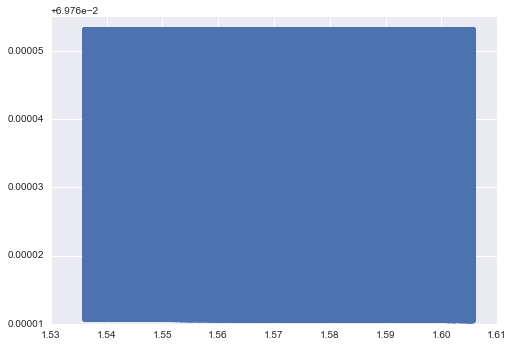

In [245]:
plt.plot(df.theta, (df.thetaprime_1 - df.theta), '.')

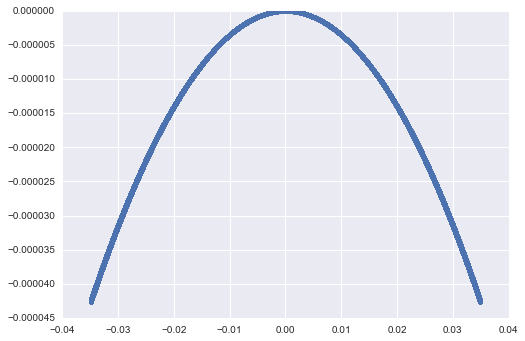

In [247]:
plt.plot(df.phi, (df.thetaprime_1 - df.theta - np.radians(4.)), '.')

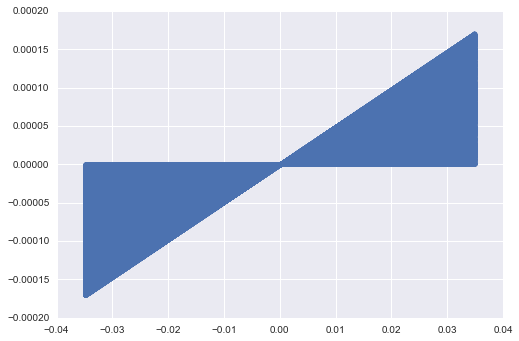

In [248]:
plt.plot(df.phi, (df.phiprime_1 - df.phi), '.')

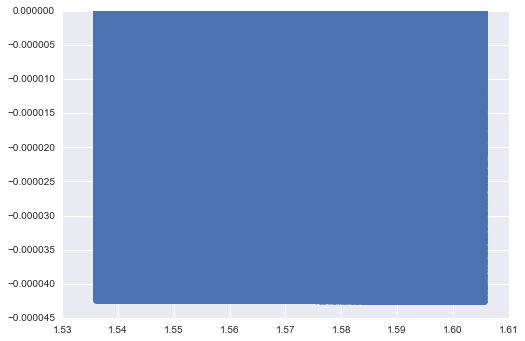

In [249]:
plt.plot(df.theta, (df.thetaprime_1 - df.theta - np.radians(4.)), '.')

Select at random 2n points from df and find their angular separations before and after the transformations

In [252]:
Nchecks = 1000
sel = np.random.choice(df.index, 2*Nchecks, replace=False)

In [253]:
np.unique(sel).size == sel.size

True

In [254]:
len(sel)

2000

In [255]:
df_a = df.ix[sel[:len(sel)/2.]]
df_b = df.ix[sel[len(sel)/2:]]

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [257]:
print(map(len, (df_a, df_b)))

[1000, 1000]


In [258]:
SepsBefore = angSep(df_a, df_b, 'theta', 'phi')

In [259]:
SepsAfter = angSep(df_a, df_b, 'thetaprime_1', 'phiprime_1')

In [260]:
np.allclose(SepsAfter, SepsBefore)

True

## Catsim Queries

In [266]:
observerMetaData = ObservationMetaData(boundType='box',
                                  pointingRA=0.,
                                  pointingDec=0.,
                                  boundLength=0.1)

In [267]:
class galCopy(InstanceCatalog):
    column_outputs = ['galtileid', 'raJ2000', 'decJ2000', 'redshift']#, 'a_d', 'b_d', 'pa_disk', 'mass_stellar', 'absmag_r_total']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e', 
                        'mass_stellar': '%8e', 'absmag_r_total': '%8e'}

In [406]:
def galTileID(tileID, galID):
    return 100000000* tileID + galID

def galIds(tileID, galTileID):
    return galTileID - 100000000* tileID

In [273]:
galaxyTiled = GalaxyTileObj()

In [411]:
constr='redshift < 0.2'
gBase = galCopy(galaxyTiled, obs_metadata=observerMetaData, constraint=constr)
gBase.write_catalog('gBase.csv')
gBase_df  = pd.read_csv('gBase.csv', delimiter=', ',index_col='#galtileid')
gBase_df.index.name = 'galtileid'
gBase_df.head()

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


,raJ2000,decJ2000,redshift
galtileid,,,
2207572926,0.001169,0.000089,0.0969
2204390270,0.001321,0.000592,0.1489
2201480140,0.001466,0.000671,0.1470
2214603211,0.001405,0.000683,0.1562
2214006934,0.001560,0.000761,0.1623


In [414]:
gBase_df['id'] = galIds(22, gBase_df.index.values)
gBase_df.set_index('id', inplace=True)
gBase_df.head()

,raJ2000,decJ2000,redshift
id,,,
7572926,0.001169,0.000089,0.0969
4390270,0.001321,0.000592,0.1489
1480140,0.001466,0.000671,0.1470
14603211,0.001405,0.000683,0.1562
14006934,0.001560,0.000761,0.1623


In [424]:
obsMetaData_1 = observerMetaData

In [425]:
obsMetaData_1.pointingDec = -4.0

In [426]:
obsMetaData_1.boundLength

0.10000000000000001

In [427]:
constr='redshift < 0.2'
gTile_1 = galCopy(galaxyTiled, obs_metadata=observerMetaData, constraint=constr)

In [428]:
gTile_1.write_catalog('gTile_1.csv')

In [437]:
gTile1_df  = pd.read_csv('gTile_1.csv', delimiter=', ', index_col='#galtileid')
gTile1_df.index.name = 'galtileid'
gTile1_df.head()

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,raJ2000,decJ2000,redshift
galtileid,,,
2107333309,0.001163,-0.068984,0.1237
2112377595,0.001630,-0.068688,0.0896
2103081785,0.001627,-0.068572,0.1496
2107224035,0.001407,-0.068818,0.1485
2109815732,0.001741,-0.068676,0.1499


In [438]:
gTile1_df['id'] = galIds(21, gTile1_df.index.values)

In [439]:
gTile1_df.set_index('id', inplace=True)

In [440]:
gTile1_df.head()

,raJ2000,decJ2000,redshift
id,,,
7333309,0.001163,-0.068984,0.1237
12377595,0.001630,-0.068688,0.0896
3081785,0.001627,-0.068572,0.1496
7224035,0.001407,-0.068818,0.1485
9815732,0.001741,-0.068676,0.1499


In [442]:
gTile1_df.index.values.min()

3439

In [443]:
gTile1_df.rename(columns={'raJ2000':'raJ2000_1', 'decJ2000':'decJ2000_1', 'redshift': 'redshift_1'},
                 inplace=True)

In [444]:
merged = pd.concat([gBase_df, gTile1_df], axis=1)

In [472]:
merged['shiftedRA']  = np.where(merged.raJ2000 < 3., merged.raJ2000, merged.raJ2000 - 2.0*np.pi)

In [474]:
merged['shiftedRA_1']  = np.where(merged.raJ2000_1 < 3., merged.raJ2000_1, merged.raJ2000_1 - 2.0*np.pi)

In [475]:
merged.head()

,raJ2000,decJ2000,redshift,raJ2000_1,decJ2000_1,redshift_1,shiftedRA,shiftedRA_1
id,,,,,,,,
3439,0.000843,0.000985,0.1980,0.000762,-0.068788,0.1980,0.000843,0.000762
9627,0.001659,-0.001398,0.1628,0.001575,-0.071173,0.1628,0.001659,0.001575
10445,0.000165,-0.001085,0.1744,0.000078,-0.070856,0.1744,0.000165,0.000078
10626,0.000229,-0.000595,0.1744,0.000143,-0.070366,0.1744,0.000229,0.000143
16122,NaN,NaN,NaN,0.001733,-0.071405,0.0882,NaN,0.001733


In [476]:
uncommon = merged[merged.isnull().any(axis=1)].copy()

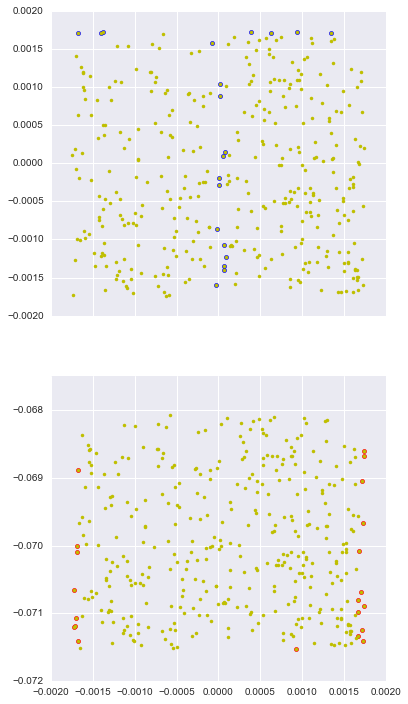

In [499]:
fig, ax = plt.subplots(2, 1, figsize=(6, 12), sharex=True)
ax[0].plot(merged.shiftedRA, merged.decJ2000, 'y.')
ax[0].scatter(uncommon.shiftedRA, uncommon.decJ2000, color='b')

ax[1].plot(merged.shiftedRA_1, merged.decJ2000_1, 'y.')
ax[1].scatter(uncommon.shiftedRA_1, uncommon.decJ2000_1, color='r')




In [323]:
gTile1_df.sort('redshift').head()

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,raJ2000,decJ2000,redshift
galtileid,,,
2107460316,0.000917,-0.070762,0.0382
2107460340,0.000907,-0.070824,0.0382
402606357940,6.282769,-0.070994,0.0404
402600000109,6.281642,-0.068593,0.0453
402600443253,6.282688,-0.071501,0.0591


In [298]:
class galBaseCopy(InstanceCatalog):
    column_outputs = ['id', 'raJ2000', 'decJ2000', 'redshift']#, 'a_d', 'b_d', 'pa_disk', 'mass_stellar', 'absmag_r_total']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e', 
                        'mass_stellar': '%8e', 'absmag_r_total': '%8e'}

In [309]:
galaxybaseObs = GalaxyObj()
galaxyBase = galBaseCopy(galaxybaseObs, obs_metadata=observerMetaData, constraint=constr)
galaxyBase.write_catalog('galaxyBase_small.csv')

In [316]:
galBase_df = pd.read_csv('galaxyBase_small.csv', delimiter=', ', index_col='#id')
galBase_df.index.name = 'id'

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [327]:
galBase_df.sort('redshift').head()

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,raJ2000,decJ2000,redshift
id,,,
371,0.001323,-0.000562,0.0421
10146853,0.000058,-0.000425,0.0452
10146863,0.000660,-0.001039,0.0452
416,6.283145,0.000352,0.0544
1605,6.282565,-0.000954,0.0545


In [328]:
from lsst.sims.utils import haversine

In [336]:
orig_1 = gBase_df.ix[2207460316]
orig_2 = gBase_df.ix[2207460340]

In [337]:
orig_2

raJ2000     0.000992
decJ2000   -0.001051
redshift    0.038200
Name: 2207460340, dtype: float64

In [331]:
rot_1 = gTile1_df.ix[2107460316]
rot_2 = gTile1_df.ix[2107460340]

In [338]:
rot_2

raJ2000     0.000907
decJ2000   -0.070824
redshift    0.038200
Name: 2107460340, dtype: float64

In [344]:
orig_sep = haversine(orig_1.decJ2000, orig_1.raJ2000, orig_2.decJ2000, orig_2.raJ2000)

In [342]:
rotated_sep = haversine(rot_1.decJ2000, rot_1.raJ2000, rot_2.decJ2000, rot_2.raJ2000)

In [346]:
np.allclose(rotated_sep, orig_sep)

True

In [351]:
def galTileID(tileID, galID):
    return 100000000* tileID + galID

def galIds(tileID, galTileID):
    return galTileID - 100000000* tileID

In [390]:
gBase_df['Id'] = galIds(22, gBase_df.index.values)
gBase_df.set_index('Id', inplace=True)

In [391]:
gBase_df.head()

,raJ2000,decJ2000,redshift,galIdFromBase
Id,,,,
3439,0.001344,0.001715,0.0564,3439
9627,0.001243,0.000790,0.1237,9627
10445,0.001709,0.001086,0.0896,10445
10626,0.001705,0.001203,0.1496,10626
29244,0.001486,0.000957,0.1485,29244


In [392]:
gTile1_df['Id'] = galIds(21, gTile1_df.index.values)

In [393]:
gTile1_df.set_index('Id', inplace=True)

In [394]:
gTile1_df.head()

,raJ2000,decJ2000,redshift
Id,,,
3439,0.001664,-0.069568,0.1337
9627,0.001551,-0.069453,0.1493
10445,0.001174,-0.069736,0.1742
10626,0.001281,-0.069714,0.1761
16122,0.001292,-0.069709,0.1737


In [401]:
merged = pd.concat([gBase_df, gTile1_df], axis=1)

In [402]:
merged

,raJ2000,decJ2000,redshift,galIdFromBase,raJ2000,decJ2000,redshift
Id,,,,,,,
3439,0.001344,0.001715,0.0564,3.439000e+03,0.001664,-0.069568,0.1337
9627,0.001243,0.000790,0.1237,9.627000e+03,0.001551,-0.069453,0.1493
10445,0.001709,0.001086,0.0896,1.044500e+04,0.001174,-0.069736,0.1742
10626,0.001705,0.001203,0.1496,1.062600e+04,0.001281,-0.069714,0.1761
16122,NaN,NaN,NaN,NaN,0.001292,-0.069709,0.1737
29244,0.001486,0.000957,0.1485,2.924400e+04,0.001584,-0.069751,0.1783
29271,0.001300,0.001029,0.1749,2.927100e+04,NaN,NaN,NaN
30339,0.001583,0.001242,0.1743,3.033900e+04,0.001614,-0.069543,0.1736
30473,0.001365,0.001316,0.1689,3.047300e+04,0.001731,-0.069670,0.1789


In [373]:
galtileIDs = galTileID(21, galIdFromBase)

In [376]:
galTileID_1 = gTile1_df.index.values
galTileID_1.sort()

In [378]:
galTileID_1[:10]

array([2100003439, 2100009627, 2100010445, 2100010626, 2100016122,
       2100029244, 2100030339, 2100030473, 2100031250, 2100031671])

In [381]:
print(len(galtileIDs), len(galTileID_1))

371 372


In [383]:
len(set(galtileIDs) - set(galTileID_1))

20

In [385]:
len(set(galTileID_1) - set(galtileIDs))

21

In [360]:
y = gBase_df.index.values
y.sort()

In [361]:
y[:10]

array([2200003439, 2200009627, 2200010445, 2200010626, 2200029244,
       2200029271, 2200030339, 2200030473, 2200031250, 2200031671])

In [363]:
galtileIDs[:10]

array([2200000259, 2200000371, 2200000416, 2200001083, 2200001605,
       2200001994, 2200002835, 2200002930, 2200003146, 2200003556])